Dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

## Import Packages

In [65]:
import numpy as np
import pandas as pd
import glob
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from PIL import Image 
from sklearn.metrics import confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split

## Reading the Images

In [52]:
#Paths
root_path = './data'
yes_path = root_path + '/yes/*'
no_path = root_path + '/no/*'
valid_extensions = ('.jpg', '.JPG', '.jpeg')  

In [53]:
#Images with tumor
tumor = []

for img_path in glob.iglob(yes_path):
    if img_path.lower().endswith(valid_extensions):  
        img = cv2.imread(img_path) #get an image
        _, img_encoded = cv2.imencode('.jpg', img) # Convert to proper format (JPEG compatible)
        img = cv2.imdecode(img_encoded, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128, 128)) #resize it
        b, g, r = cv2.split(img) #get the BGR values
        cv2.merge([r, g, b])
        tumor.append(img)
        
tumor = np.array(tumor)
len(tumor)

154

In [54]:
#Images without tumor
healthy = []

for img_path in glob.iglob(no_path):
    if img_path.lower().endswith(valid_extensions):  
        img = cv2.imread(img_path) #get an image
        _, img_encoded = cv2.imencode('.jpg', img) # Convert to proper format (JPEG compatible)
        img = cv2.imdecode(img_encoded, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (128, 128)) #resize it
        b, g, r = cv2.split(img) #get the BGR values
        cv2.merge([r, g, b])
        healthy.append(img)
        
healthy = np.array(healthy)
len(healthy)

97

In [55]:
print(tumor.shape)
print(healthy.shape)

(154, 128, 128, 3)
(97, 128, 128, 3)


## Visualizing

In [56]:
def plotimg(healthy, tumor, num = 5):
    healthy_imgs = healthy[np.random.choice(healthy.shape[0], num, replace = False)]
    tumor_imgs = tumor[np.random.choice(tumor.shape[0], num, replace = False)]
    plt.figure(figsize = (16, 9))
    #plot healthy imgs
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.title('healthy')
        plt.imshow(healthy_imgs[i])
    #plot tumor imgs
    plt.figure(figsize = (16, 9))
    for i in range(num):
        plt.subplot(1, num, i + 1)
        plt.title('tumor')
        plt.imshow(tumor_imgs[i])
    

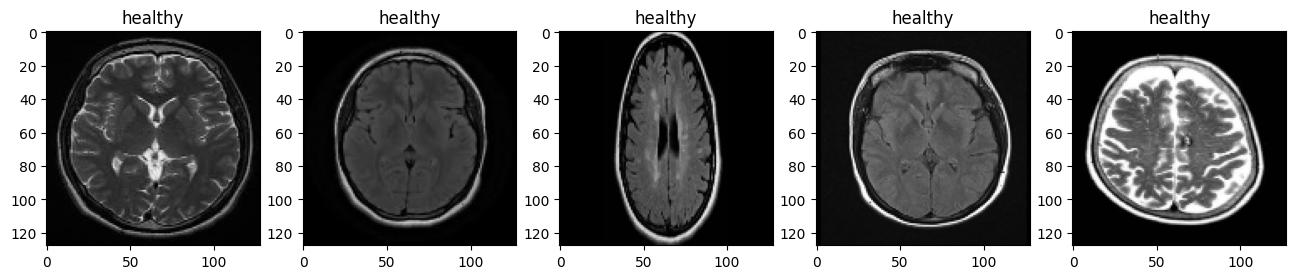

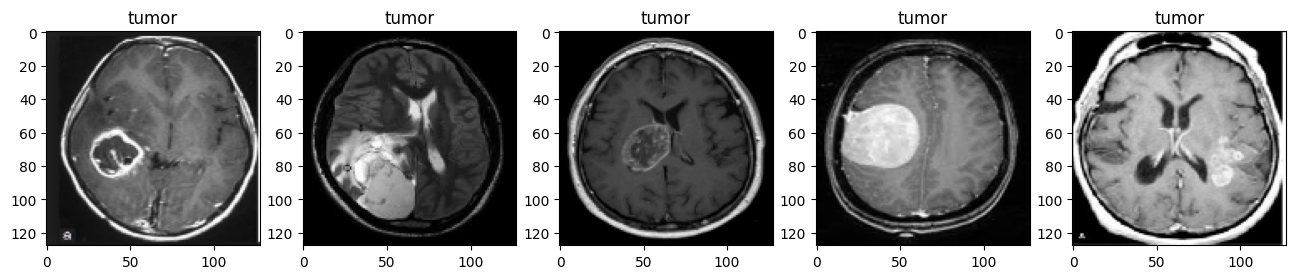

In [57]:
plotimg(healthy, tumor)

## Dataset

In [58]:
class MRI(Dataset):
    def __init__(self):
        tumor = []
        healthy = []
        
        for img_path in glob.iglob(yes_path):
            if img_path.lower().endswith(valid_extensions):  
                img = cv2.imread(img_path) #get an image
                _, img_encoded = cv2.imencode('.jpg', img) # Convert to proper format (JPEG compatible)
                img = cv2.imdecode(img_encoded, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (128, 128)) #resize it
                b, g, r = cv2.split(img) #get the BGR values
                cv2.merge([r, g, b])
                img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
                tumor.append(img)
                
        for img_path in glob.iglob(no_path):
            if img_path.lower().endswith(valid_extensions):  
                img = cv2.imread(img_path) #get an image
                _, img_encoded = cv2.imencode('.jpg', img) # Convert to proper format (JPEG compatible)
                img = cv2.imdecode(img_encoded, cv2.IMREAD_COLOR)
                img = cv2.resize(img, (128, 128)) #resize it
                b, g, r = cv2.split(img) #get the BGR values
                cv2.merge([r, g, b])
                img = img.reshape((img.shape[2], img.shape[0], img.shape[1]))
                healthy.append(img)
        
        tumor = np.array(tumor, dtype = np.float32)
        healthy = np.array(healthy, dtype = np.float32)

        tumor_label = np.ones(tumor.shape[0], dtype = np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype = np.float32)
        
        self.images = np.concatenate((tumor, healthy), axis = 0)
        self.labels = np.concatenate((tumor_label, healthy_label))

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, index):
        sample = {'image': self.images[index], 'label': self.labels[index]}
        return sample

    def normalize(self):
        self.images = self.images / 255.0

## Data Loader

In [59]:
mri = MRI()
loader = DataLoader(mri, batch_size = 10, shuffle = True)

In [60]:
for sample in loader:
    img = sample['image']

 ## Model

In [61]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = (5, 5)),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
            nn.Conv2d(in_channels = 6, out_channels = 16, kernel_size = (5, 5)),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=5),
        )
        self.fc_model = nn.Sequential(
            nn.Linear(in_features=256, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=1),
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1) #flatten
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
        

## Evaluate

In [62]:
mri_ds = MRI()
mri_ds.normalize()
device = torch.device('cude:0' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
loader = DataLoader(mri_ds, batch_size = 32, shuffle = False)

In [63]:
model.eval()
output = []
y_true = []

with torch.no_grad():
    for D in loader:
        image = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(image)
        output.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [64]:
output = np.concatenate(output, axis = 0).squeeze()
output.shape

(251,)